## Does the CMIP5 emergent constraint on SH jet shifts work in CMIP6?

Kidston and Gerber (2010) (https://doi.org/10.1029/2010GL042873) demonstrated in the annual mean that there was a relationship between the SH climatological jet latitude in the present day and how much the SH jet latitude shifted further poleward under anthropogenic climate change.  Suggesting that there is an emergent constraint on the SH jet latitude change i.e., we know where the real worl jet latitude is and we can use the inter-model relationship between jet latitude and jet shift, to predict where the real world jet will shift in the future.  This relationship was further demonstrated by Simpson and Polvani (https://doi.org/10.1002/2016GL067989) to have a strong seasonality, with the emergent constraint only being strong in the SH winter (JJA).

<img src="simpsonandpolvani.png">

In [1]:
# Loading libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe
import dask
import season_util as su
import jetlatcalcs as jlat
import intake

you have successfully imported the jet latitude calculation subroutines


In [2]:
from ncar_jobqueue import NCARCluster
from distributed import Client
cluster = NCARCluster(project='P04010022')
cluster.adapt(minimum_jobs=1, maximum_jobs=10)
client = Client(cluster)
cluster

/ncar/usr/jupyterhub/envs/cmip6-201910/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [ ]:
#

In [16]:
# model=['AWI-CM-1-1-MR','BCC-CSM2-MR','BCC-ESM1',
#        'CAMS-CSM1-0','CanESM5','CNRM-CM6-1','CNRM-ESM2-1','E3SM-1-0',
#        'MIROC6',
#        'HadGEM3-GC31-LL','UKESM1-0-LL','MRI-ESM2-0',
#        'GISS-E2-1-G','GISS-E2-1-H','CESM2','CESM2-WACCM',
#        'NorESM2-LM','GFDL-AM4','GFDL-ESM4','SAM0-UNICON']

model = ['IPSL-CM6A-LR','CanESM5']

var = ["ua"]
col = intake.open_esm_datastore("/glade/collections/cmip/catalog/\
intake-esm-datastore/catalogs/glade-cmip6.json")
cat = col.search(activity_id="CMIP",experiment_id="piControl",
                variable_id=var, table_id="Amon", source_id=model)
cat4x = col.search(activity_id="CMIP",experiment_id="abrupt-4xCO2",
                variable_id=var, table_id="Amon", source_id=model)
dset_dict_pi = cat.to_dataset_dict(cdf_kwargs={'chunks': {"time": 36}, 
                                    'decode_times': True})
dset_dict_4x = cat4x.to_dataset_dict(cdf_kwargs={'chunks': {"time": 36}, 
                                    'decode_times': True})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 2 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 2 group(s)


Note, currently all models piControls start in January.  This is going to fail for a model where that's not the case e.g., often the met office.  We need to do something fancier here to make sure it works more generally

In [17]:
#calculate the mean over longitude, ensemble members and desired time period and pick out 700hPa
pi_mean = {}
abrupt4x_mean = {}
for key, ds in dset_dict_pi.items():
    pi_mean[key] = ds.isel(time = slice(0,100*12))
    pi_mean[key] = pi_mean[key].sel(plev=70000.).mean(dim=["member_id","lon"])
for key, ds in dset_dict_4x.items():
    abrupt4x_mean[key] = ds.isel(time = slice(50*12,100*12))
    abrupt4x_mean[key] = ds.sel(plev=70000.).mean(dim=["member_id","lon"])

In [18]:
pi_mean = dask.compute(pi_mean)
abrupt4x_mean = dask.compute(abrupt4x_mean)

In [ ]:
print(pi_mean)

In [ ]:
#note we're having issues with gregorian calendars here

In [22]:
xds1=pi_mean[0]["CMIP.IPSL.IPSL-CM6A-LR.piControl.Amon.gr"]
xds2=pi_mean[0]["CMIP.CCCma.CanESM5.piControl.Amon.gn"]

In [53]:
import cftime
#xds1["time"] = cftime.DatetimeProlepticGregorian
xds1=xr.decode_cf(xds1)

In [54]:
print(xds1.time)
print(xds2.time)

<xarray.DataArray 'time' (time: 1200)>
array([Timestamp('1850-01-16 12:00:00'), Timestamp('1850-02-15 00:00:00'),
       Timestamp('1850-03-16 12:00:00'), ..., Timestamp('1949-10-16 12:00:00'),
       Timestamp('1949-11-16 00:00:00'), Timestamp('1949-12-16 12:00:00')],
      dtype=object)
Coordinates:
    plev     float32 ...
  * time     (time) object 1850-01-16T12:00:00 ... 1949-12-16T12:00:00
Attributes:
    axis:           T
    standard_name:  time
    long_name:      Time axis
    bounds:         time_bounds
<xarray.DataArray 'time' (time: 1200)>
array([cftime.DatetimeNoLeap(5201, 1, 16, 12, 0, 0, 0, 1, 16),
       cftime.DatetimeNoLeap(5201, 2, 15, 0, 0, 0, 0, 3, 46),
       cftime.DatetimeNoLeap(5201, 3, 16, 12, 0, 0, 0, 4, 75), ...,
       cftime.DatetimeNoLeap(5300, 10, 16, 12, 0, 0, 0, 2, 289),
       cftime.DatetimeNoLeap(5300, 11, 16, 0, 0, 0, 0, 5, 320),
       cftime.DatetimeNoLeap(5300, 12, 16, 12, 0, 0, 0, 0, 350)], dtype=object)
Coordinates:
    plev     float64 7e+04

In [33]:
xds2["ua"].groupby('time.season')

DataArrayGroupBy, grouped over 'season' 
4 groups with labels 'DJF', 'JJA', 'MAM', 'SON'.

In [46]:
#xds1["ua"].groupby('time.month')
print(xds1["time"].groupby('time.month'))
#xds1month['month'] = xds1['time'].dt.month

AttributeError: 'IndexVariable' object has no attribute 'month'

In [36]:
#xds1["ua"].groupby('time.season')
#xds1.time.dt.season
xds1

<xarray.Dataset>
Dimensions:  (lat: 143, time: 1200)
Coordinates:
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
    plev     float32 70000.0
  * time     (time) object 1850-01-16T12:00:00 ... 1949-12-16T12:00:00
Data variables:
    ua       (time, lat) float32 nan -2.612786 -2.934967 ... 0.5326388 1.8189867

In [37]:
xds2

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 64, time: 1200)
Coordinates:
  * lat       (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
    plev      float64 7e+04
  * time      (time) object 5201-01-16 12:00:00 ... 5300-12-16 12:00:00
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (lat, bnds) float64 -90.0 -86.58 -86.58 ... 86.58 86.58 90.0
    lon_bnds  (bnds) float64 177.2 180.0
    ua        (time, lat) float32 -1.5328262 -0.39493603 ... 0.90615076

In [ ]:
# calculate JJA season average
#xr.Dataset.drop(dset_dict_pi["CMIP.IPSL.IPSL-CM6A-LR.piControl.Amon.gr"])
#del dset_dict_pi["CMIP.MRI.MRI-ESM2-0.piControl.Amon.gn"]
#del dset_dict_4x["CMIP.MRI.MRI-ESM2-0.abrupt-4xCO2.Amon.gn"]
pi_jja = {}
for key, x in dset_dict_pi.items():
    print(key)
    pi_jja[key] = su.season_mean(pi_mean[0][key],"ua",season="JJA")
    
abrupt4x_jja = {}
for key, x in dset_dict_4x.items():
    abrupt4x_jja[key] = su.season_mean(abrupt4x_mean[0][key],"ua",season="JJA")

In [37]:
#calculate jet latitude
jlathist = {}
jspeedhist = {}
for key, x in dset_dict_pi.items():
    jlatv, jspeedv = jlat.calcjetlat( pi_jja[key], -80, -20)
    jlathist[key] = jlatv
    jspeedhist[key] = jspeedv
    
jlatssp370 = {}
jspeedssp370 = {}
for key, x in dset_dict_4x.items():
    jlatv, jspeedv = jlat.calcjetlat( abrupt4x_jja[key], -80, -20)
    jlatssp370[key] = jlatv
    jspeedssp370[key] = jspeedv

In [38]:
#read in cmip5 data
cmip5path = "cmip5_jetlatitudes_pi4xco2.nc"
cmip5 = xr.open_dataset(cmip5path)
#calculate linear regression line
coefs = np.polyfit(cmip5.jlatpi, cmip5.jlat4x - cmip5.jlatpi, 1)
acmip5=coefs[1]
bcmip5=coefs[0]
xvalues = [i for i in range(-55,-35)]
yvalues = [acmip5 + bcmip5*i for i in xvalues]

In [ ]:
#predict cmip6 values from cmip5
jlathistvalues = list(jlathist.values())
ycmip6 = [acmip5 + bcmip5*i for i in jlathistvalues]
ycmip6

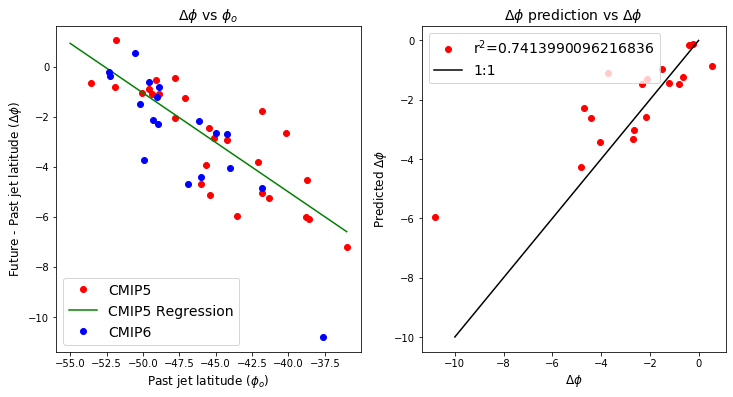

In [53]:
# plotting
jlathistvalues = list(jlathist.values())
jlatssp370values = list(jlatssp370.values())
jlatdif = [a - b for a, b in zip(jlatssp370values, jlathistvalues)]
jlatdifpredict = [acmip5 + bcmip5*i for i in jlathistvalues]
fig = plt.figure(figsize=(12, 6),facecolor='w')
ax = fig.add_subplot(1, 2, 1)
#ax.plot(jlathistvalues,jlatdif, color='red', label='CMIP6', marker='o', linestyle='none')
ax.plot(cmip5.jlatpi, cmip5.jlat4x-cmip5.jlatpi, color='red', label='CMIP5', marker='o', linestyle='none')
ax.plot(xvalues,yvalues,color='green', label='CMIP5 Regression', linestyle='solid')
ax.plot(jlathistvalues,jlatdif, color='blue', label='CMIP6', marker='o', linestyle='none')
ax.set_xlabel('Past jet latitude ($\phi_{o}$)', fontdict={'size':12});
ax.set_ylabel('Future - Past jet latitude ($\Delta\phi$)', fontdict={'size':12});  
ax.set_title('$\Delta\phi$ vs $\phi_{o}$', fontdict={'size':14})
ax.legend(loc='lower left', fontsize=14)


r = np.corrcoef(jlatdif,jlatdifpredict)
r=r[0,1]
rsq = r**2

ax2=fig.add_subplot(1,2,2)
ax2.plot(jlatdif, jlatdifpredict, color='red', label='r$^{2}$='+str(rsq), marker='o', linestyle='none')
ax2.set_xlabel('$\Delta\phi$', fontdict={'size':12})
ax2.set_ylabel('Predicted $\Delta\phi$', fontdict={'size':12})
ax2.plot([-10,0],[-10,0], color='black', label='1:1', linestyle='solid')
ax2.set_title('$\Delta\phi$ prediction vs $\Delta\phi$', fontdict={'size':14})
ax2.legend(loc='upper left', fontsize=14)
